In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from pathlib import Path
import numpy as np

import sys
sys.path.append('../')
sys.path.append('../VAE')
from model import DCEVAE    
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from dataset import SimUCIAdult

from copy import deepcopy

In [3]:

class Args:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    r_dim = 3 
    d_dim = 6
    ur_dim = 3
    ud_dim = 4
    h_dim = 100
    act_fn = 'Tanh'
    use_label = False
    dataset = 'adult'
args = Args()

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FONTSIZE = 20
METRIC_DICT = {'cf_effect':r'$TE$',
                'cf_effect0':r'$TE_0$',
                'cf_effect1':r'$TE_1$'}

In [5]:
def infer_u(model, r, d, a, y):
    device = r.device
    u_mu, u_logvar = model.q_u(r.to(device), d.to(device), a.to(device),y )
    u_prev = model.reparameterize(u_mu, u_logvar)
    return u_prev

def gen_x(model, u, a):
    device = u.device

    r, d, _ = model.reconstruct_hard(u, a.to(device))
    x = torch.cat([r, d], dim=1)

    return x

def cf_eval(y, y_cf, a):
    a = a.squeeze()
    mask1 = (a == 0)
    mask2 = (a == 1)
    
    cf_effect = np.abs(y_cf - y)
    o1 = cf_effect[mask1]
    o2 = cf_effect[mask2]
    return np.sum(cf_effect) / cf_effect.shape[0], np.sum(o1) / o1.shape[0], np.sum(o2) / o2.shape[0]


def cvae_prepare_data(datasets, model):

    data_dict = {}
    model.eval()

    for split in ['train', 'test']:
        cur_data_dict = {}
        dataset = datasets[split]

        r,d,a,y,u = dataset.r, dataset.d, dataset.a, dataset.y, dataset.u
        x = torch.cat([r,d], dim=1)
        x_cf, a_cf, y_cf = dataset.x_cf, dataset.a_cf, dataset.y_cf 
        

        x = x.to(DEVICE)
        r = r.to(DEVICE)
        d = d.to(DEVICE)
        u = u.to(DEVICE)
        y = y.to(DEVICE)
        a = a.to(DEVICE)
        x_cf = x_cf.to(DEVICE)
        y_cf = y_cf.to(DEVICE)
        a_cf = a_cf.to(DEVICE)

        cur_data_dict['x'] = x
        cur_data_dict['y'] = y 
        cur_data_dict['a'] = a
        cur_data_dict['u'] = u
        cur_data_dict['x_cf'] = x_cf    
        cur_data_dict['y_cf'] = y_cf
        cur_data_dict['a_cf'] = a_cf

        u_hat = infer_u(model, r, d, a, None)
        u_cf_hat = infer_u(model, x_cf[:,:3], x_cf[:,3:], a_cf, None)
        x_cf_uhat = gen_x(model, u_hat, a_cf)
        x_cf_cf_uhat = gen_x(model, u_cf_hat, a)


        cur_data_dict['u_hat'] = u_hat
        cur_data_dict['u_cf_hat'] = u_cf_hat
        cur_data_dict['x_cf_uhat'] = x_cf_uhat
        cur_data_dict['x_cf_cf_uhat'] = x_cf_cf_uhat

            
        for key, data in cur_data_dict.items():
            cur_data_dict[key] = data.detach().cpu().numpy()
            
        data_dict[split] = cur_data_dict
        

    return data_dict

In [6]:
def ermsoft_classifier(data_dict, clf, alpha=1):
    train_dat = data_dict["train"]
    test_dat = data_dict["test"]
    
    inputs = np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1)
    y = train_dat["y"].ravel()

    clf.fit(inputs, y)
    train_acc = accuracy_score(y, clf.predict(inputs))



    y_factual = clf.predict(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    
    acc = accuracy_score(test_dat["y"].ravel(), y_factual.ravel())

    y_counter = clf.predict(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf

def cfesoft_classifier(data_dict, clf, alpha=1):

    train_dat = data_dict["train"]
    test_dat = data_dict["test"]

    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())
    
    inputs =  train_dat["u_hat"]
    y = train_dat["y"].ravel()
    clf.fit(inputs, y)
    train_acc = accuracy_score(y, clf.predict(inputs))


    y_factual_cfe = clf.predict_proba(test_dat["u_hat"])
    y_factual_erm = clf_erm.predict_proba(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_cfe + (1-alpha) * y_factual_erm
    y_factual = y_factual.argmax(axis=1)
    acc = accuracy_score(test_dat["y"].ravel(), y_factual.ravel())


    y_counter_cfe = clf.predict_proba(test_dat["u_cf_hat"])
    y_counter_erm = clf_erm.predict_proba(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_cfe + (1-alpha) * y_counter_erm
    y_counter = y_counter.argmax(axis=1)
    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf

def cfrsoft_classifier(data_dict, clf, alpha=1):

    train_dat = data_dict["train"]
    test_dat = data_dict["test"]

    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())
    
    inputs = np.concatenate([train_dat["u_hat"], 
                        (train_dat["x"] + train_dat["x_cf_uhat"]) / 2], axis=1)
    y = train_dat["y"].ravel()
    clf.fit(inputs, y)
    train_acc = accuracy_score(y, clf.predict(inputs))

    y_factual_cfr = clf.predict_proba(np.concatenate([
        test_dat["u_hat"],
        (test_dat["x"] + test_dat["x_cf_uhat"]) / 2
    ], axis=1))
    y_factual_erm = clf_erm.predict_proba(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_cfr + (1-alpha) * y_factual_erm
    y_factual = y_factual.argmax(axis=1)
    acc = accuracy_score(test_dat["y"].ravel(), y_factual.ravel())

    y_counter_cfr = clf.predict_proba(np.concatenate([
        test_dat["u_cf_hat"],
        (test_dat["x_cf"] + test_dat["x_cf_cf_uhat"]) / 2
    ], axis=1))
    a = test_dat["a"]
    y_counter_erm = clf_erm.predict_proba(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_cfr + (1-alpha) * y_counter_erm
    y_counter = y_counter.argmax(axis=1)
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf


def pcf_mix(y_score, ycf_score, a, is_cf=False):
    # attribute corresponding to y
    a_0_indices = a == 0
    a_1_indices = a == 1
    a_0_ratio = np.sum(a_0_indices) / len(a)
    a_1_ratio = 1-a_0_ratio
    if is_cf is True:
        # we need to use the ratio in the real data
        a_0_ratio, a_1_ratio = a_1_ratio, a_0_ratio

    # a_0_ratio = 0.5
    # a_1_ratio = 0.5
    y_output = np.zeros_like(y_score)
    y_output[a_0_indices] = y_score[a_0_indices] * a_0_ratio + ycf_score[a_0_indices] * a_1_ratio
    y_output[a_1_indices] = y_score[a_1_indices] * a_1_ratio + ycf_score[a_1_indices] * a_0_ratio

    return y_output

def pcfsoft_classifier(data_dict, clf, alpha=1):
    train_dat = data_dict["train"]
    test_dat = data_dict["test"]

    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())
    
    inputs = np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1)
    y = train_dat["y"].ravel()
    clf.fit(inputs, y)
    train_acc = accuracy_score(y, clf.predict(inputs))

    # ======= factual pred ======= #
    y_factual_score = clf.predict_proba(np.concatenate([test_dat["x"],
                                                test_dat['a']],axis=1))
    y_factual_cf_score = clf.predict_proba(np.concatenate([test_dat["x_cf_uhat"],
                                                     test_dat['a_cf']],axis=1))
    
    y_factual_pcf = pcf_mix(y_factual_score, y_factual_cf_score, test_dat['a'].ravel())

    y_factual_erm = clf_erm.predict_proba(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_pcf + (1-alpha) * y_factual_erm
    y_factual = y_factual.argmax(axis=1)
    acc = accuracy_score(test_dat["y"].ravel(), y_factual.ravel())

    # ======= counter pred ======= #
    y_counter_score = clf.predict_proba(np.concatenate([test_dat["x_cf"],
                                                        test_dat['a_cf']],axis=1))
    y_counter_cf_score = clf.predict_proba(np.concatenate([test_dat["x_cf_cf_uhat"],
                                                        test_dat['a']],axis=1))
    y_counter_pcf = pcf_mix(y_counter_score, y_counter_cf_score, test_dat['a_cf'].ravel(),is_cf=True)
    y_counter_erm = clf_erm.predict_proba(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_pcf + (1-alpha) * y_counter_erm
    y_counter = y_counter.argmax(axis=1)
    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf

def pcfaugsoft_classifier(data_dict, clf, alpha=1):
    train_dat = data_dict["train"]
    test_dat = data_dict["test"]
    
    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())

    inputs = np.concatenate([
    np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1),
    np.concatenate([train_dat["x_cf_uhat"],
                             train_dat['a_cf']],axis=1)],axis=0)
    y = np.concatenate([train_dat["y"],train_dat["y"]],axis=0).ravel()
    clf.fit(inputs, y)

    train_acc = accuracy_score(y, clf.predict(inputs))

    # ======= factual pred ======= #
    y_factual_score = clf.predict_proba(np.concatenate([test_dat["x"],
                                                test_dat['a']],axis=1))
    y_factual_cf_score = clf.predict_proba(np.concatenate([test_dat["x_cf_uhat"],
                                                     test_dat['a_cf']],axis=1))
    
    y_factual_pcf = pcf_mix(y_factual_score, y_factual_cf_score, test_dat['a'].ravel())
    
    y_factual_erm = clf_erm.predict_proba(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_pcf + (1-alpha) * y_factual_erm
    y_factual = y_factual.argmax(axis=1)
    acc = accuracy_score(test_dat["y"].ravel(), y_factual.ravel())

    # ======= counter pred ======= #
    y_counter_score = clf.predict_proba(np.concatenate([test_dat["x_cf"],
                                                        test_dat['a_cf']],axis=1))
    y_counter_cf_score = clf.predict_proba(np.concatenate([test_dat["x_cf_cf_uhat"],
                                                        test_dat['a']],axis=1))
    y_counter_pcf = pcf_mix(y_counter_score, y_counter_cf_score, test_dat['a_cf'].ravel(),is_cf=True)
    y_counter_erm = clf_erm.predict_proba(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_pcf + (1-alpha) * y_counter_erm
    y_counter = y_counter.argmax(axis=1)

    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf


In [7]:
def eval_ild(global_dir,
             all_res,
             regressor_type='ridge'
             ):

    seed_list = [1,2,3,4,5]
    #seed_list = [1,2]
    for seed in seed_list:

        args.seed = seed
        train_set = SimUCIAdult(split='train', root=global_dir)
        test_set = SimUCIAdult(split='test', root=global_dir)
        datasets = {'train':train_set, 'test':test_set}

        model_dir = global_dir / f'adult/est/dcevae/a_r_1_a_d_1_a_y_1_a_h_0.1_a_f_0.0_u_0.5_ur_3_ud_4_run_{seed}_use_label_False/model.pth' 
        model = DCEVAE(r_dim=args.r_dim,
                        d_dim=args.d_dim, 
                        sens_dim=1, 
                        label_dim=1, 
                        args=args).to(args.device)
        #model.load_state_dict(torch.load(model_dir))
        model = torch.load(model_dir)

        data_dict = cvae_prepare_data(datasets, model)

        for lamb in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            for method, classifier in zip(['cfr', 'cfe','pcf', 'pcfaug','erm'],
                                        [cfrsoft_classifier, cfesoft_classifier, pcfsoft_classifier, pcfaugsoft_classifier, ermsoft_classifier]):
                if regressor_type == 'mlp':
                    predictor =  MLPClassifier()
                else:
                    raise ValueError("Invalid regressor type")
                train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf = classifier(data_dict, predictor, alpha=lamb)
                res = dict()
                res['seed'] = seed
                res['train_acc'] = train_acc
                res['test_acc'] = acc
                res['method'] = method
                res['clf'] = clf
                res['cf_effect'] = cf_effect
                res['cf_effect0'] = cf_effect0
                res['cf_effect1'] = cf_effect1
                res['lamb'] = lamb
                all_res = all_res.append(res, ignore_index=True)

    return all_res

In [8]:

def vis_ild_alg(all_res, save_dir=None,mute=[]):
# Split the 'method' column to separate 'method' and 'group'
    
    all_res = all_res.copy()

    #display(all_res)
    if len(mute)>0:
        for mm in mute:
            all_res = all_res[all_res['method']!=mm]
    #display(all_res)
    replace_dict = {}
    replace_dict['cda'] = 'CDA'
    replace_dict['cfe'] = 'CFU'
    replace_dict['cfr'] = 'CFR'
    replace_dict['erm'] = 'ERM'
    replace_dict['ermaug'] = 'ERM-A'
    replace_dict['npcf'] = 'nPCF'
    replace_dict['pcf'] = 'PCF'
    replace_dict['pcfy'] = 'PCFy'
    replace_dict['pcfycf'] = 'PCFycf'
    replace_dict['pcfaug'] = 'PCF-CRM'
    for alpha in [0,0.2,0.4,0.6,0.8,1]:
        replace_dict[alpha] = f'PCFaug-{alpha}'

    all_res['method'] = all_res['method'].replace(replace_dict)
    all_res['test_error'] = 1 - all_res['test_acc']
    all_res = all_res.groupby(by=['method','lamb']).mean().reset_index()
    #all_res = all_res.sort_values(by=['method', 'lamb'])
    lamb_order = sorted(all_res['lamb'].unique())
    print(lamb_order)

        
    all_res['style'] = all_res['method']

    # Define the plot size
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

    for col in ['cf_effect']:
        fig, ax = plt.subplots(figsize=(10,6))
        # Create the scatter plot with unique styles
        sns.scatterplot(data=all_res, x=col, y='test_error', style='method', hue='lamb', s=200, ax=ax)

        for method in all_res['method'].unique():
            method_data = all_res[all_res['method'] == method]
            #sns.lineplot(data=method_data, x=col, y='test_error', ax=ax, label=method, legend=False)
            ax.plot(method_data[col], method_data['test_error'], label='_nolegend_', linestyle=':',alpha=0.5)
        
        #ax.set_title(col)
        ax.set_xlabel(METRIC_DICT[col],fontsize=FONTSIZE)
        ax.set_ylabel('Error',fontsize=FONTSIZE)
        ax.legend(fontsize=FONTSIZE,markerscale=2, bbox_to_anchor=(1, 1), loc='upper left')
        plt.xticks(fontsize=FONTSIZE, rotation=30)
        plt.yticks(fontsize=FONTSIZE)

        #plt.tight_layout()
        # plt.show()
        if save_dir:
            plt.savefig(f'{save_dir}_{col}.png', bbox_inches='tight',dpi=200)
            plt.show()
        else:
            plt.show()
        

Current CPU random seed 1


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Current CPU random seed 2
Current CPU random seed 3


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Current CPU random seed 4


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Current CPU random seed 5


/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/min/a/zhou1059/miniconda3/envs/causal/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


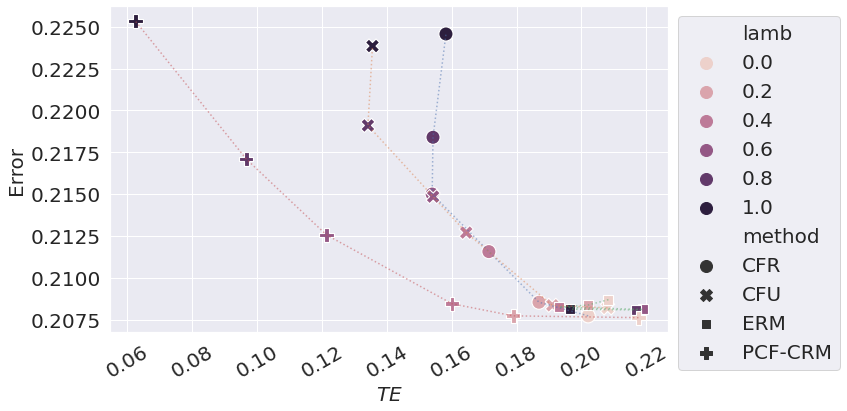

In [9]:

all_res = pd.DataFrame()

# ILD
clf_name = 'mlp'
global_dir = Path('../VAE/saved/final')
all_res = eval_ild(global_dir,
                 all_res,
                 regressor_type=clf_name)
vis_ild_alg(all_res, save_dir=f'../figures/adult/estaug_{clf_name}',mute=['pcf'])
